<a href="https://colab.research.google.com/github/ladijadi/DM_Deep_Learning/blob/main/DM_deepleanring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color=darkred> **DM de deep learning ** :
Votre objectif va être de faire toutes les démarches d'un projet d'IA. Penser à expliquer dans des blocks de texte votre démarche et l'analyse de vos résultats.

## Cas d'usage

Votre client est un cabinet médical. Celui-ci pousse ses patientes à faire des dépistages du cancer du sein en fonction de leur âge. Malheureusement l'âge n'est pas le seul critère à prendre en compte. Il veut donc élargir ses récommandations de dépistages en prenant d'autres critères.  

## Données

Vous disposez du jeu de données suivant sur huggingface : **tarekmasryo/cancer-risk-factors**
Celui-ci classe le risque de cancer du sein en 3 catégories : low, medium, high.


**Le resultat du DM est à envoyer à l'adresse suivante :
alice.petit45@gmail.com**

Vous avez jusqu'au 15 janvier maximum.



# DM Deep Learning - Prédiction du risque de cancer du sein

## 1. Contexte du projet
Le cabinet médical souhaite améliorer sa stratégie de dépistage du cancer du sein.
Jusqu'ici, l'âge était utilisé comme critère principal pour recommander les mammographies.
Cependant, de nombreux autres facteurs peuvent influencer le risque : antécédents familiaux, mutations génétiques, habitudes de vie, exposition à certains risques…

Pour aider le cabinet à mieux cibler ses patientes, je développe un modèle d'intelligence artificielle qui prédit un **niveau de risque** (`Low`, `Medium`, `High`) à partir de différents facteurs médicaux et comportementaux.

## 2. Données utilisées
J'utilise le dataset public **"Cancer Risk Factors & Types"** disponible sur HuggingFace.  
Ce dataset contient différents types de cancers.  
Pour respecter le cas d'usage, je filtre uniquement les patientes concernées par le **cancer du sein**.

## 3. Méthodologie (Cycle CRISP)
Je suis les étapes enseignées en cours :
1. Compréhension métier  
2. Compréhension des données  
3. Préparation des données  
4. Modélisation (réseau de neurones MLP)  
5. Évaluation du modèle  
6. Explicabilité (méthode Leave-One-Out)  
7. Conclusion et recommandations

Chaque étape est expliquée dans le notebook, avec des blocs de texte justifiant les choix et analysant les résultats.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import models, layers

## 1. Chargement des données
Je commence par charger le dataset fourni sur HuggingFace. L'objectif est d'obtenir un premier aperçu des colonnes disponibles et de vérifier que les données s'affichent correctement avant toute transformation.

In [3]:
df = pd.read_csv("cancer-risk-factors.csv")
df.head()

,Patient_ID,Cancer_Type,Age,Gender,Smoking,Alcohol_Use,Obesity,Family_History,Diet_Red_Meat,Diet_Salted_Processed,...,Physical_Activity,Air_Pollution,Occupational_Hazards,BRCA_Mutation,H_Pylori_Infection,Calcium_Intake,Overall_Risk_Score,BMI,Physical_Activity_Level,Risk_Level
0,LU0000,Breast,68,0,7,2,8,0,5,3,...,4,6,3,1,0,0,0.398696,28.0,5,Medium
1,LU0001,Prostate,74,1,8,9,8,0,0,3,...,1,3,3,0,0,5,0.424299,25.4,9,Medium
2,LU0002,Skin,55,1,7,10,7,0,3,3,...,1,8,10,0,0,6,0.605082,28.6,2,Medium
3,LU0003,Colon,61,0,6,2,2,0,6,2,...,6,4,8,0,0,8,0.318449,32.1,7,Low
4,LU0004,Lung,67,1,10,7,4,0,6,3,...,9,10,9,0,0,5,0.524358,25.1,2,Medium


## 2. Compréhension des données

In [4]:
# informations sur le dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               2000 non-null   object 
 1   Cancer_Type              2000 non-null   object 
 2   Age                      2000 non-null   int64  
 3   Gender                   2000 non-null   int64  
 4   Smoking                  2000 non-null   int64  
 5   Alcohol_Use              2000 non-null   int64  
 6   Obesity                  2000 non-null   int64  
 7   Family_History           2000 non-null   int64  
 8   Diet_Red_Meat            2000 non-null   int64  
 9   Diet_Salted_Processed    2000 non-null   int64  
 10  Fruit_Veg_Intake         2000 non-null   int64  
 11  Physical_Activity        2000 non-null   int64  
 12  Air_Pollution            2000 non-null   int64  
 13  Occupational_Hazards     2000 non-null   int64  
 14  BRCA_Mutation           

In [5]:
#Vérification de l'unicité de Patient_ID
df['Patient_ID'].is_unique

True

L'identifiant est unique.

In [6]:
#Vérification des lignes dupliquées
df[df.duplicated()]

,Patient_ID,Cancer_Type,Age,Gender,Smoking,Alcohol_Use,Obesity,Family_History,Diet_Red_Meat,Diet_Salted_Processed,...,Physical_Activity,Air_Pollution,Occupational_Hazards,BRCA_Mutation,H_Pylori_Infection,Calcium_Intake,Overall_Risk_Score,BMI,Physical_Activity_Level,Risk_Level


Ce dataset ne présente pas de ligne dupliquée.

In [7]:
#Vérification des valeurs manquantes
df.isnull().sum()

,0
Patient_ID,0
Cancer_Type,0
Age,0
Gender,0
Smoking,0
Alcohol_Use,0
Obesity,0
Family_History,0
Diet_Red_Meat,0
Diet_Salted_Processed,0


Le dataset ne présente pas de valeurs manquantes

## 3. Filtrage des données : cas d'usage "cancer du sein"

Le cas d'usage du cabinet médical porte uniquement sur le cancer du sein.  
Le dataset initial contient plusieurs types de cancer : Breast, Lung, Colon, Skin, Prostate.

Pour être cohérent avec la demande métier, je filtre les données afin de ne conserver que les patientes atteintes d'un cancer du sein. Cela simplifie la modélisation et permet d'obtenir un modèle spécialisé et pertinent.

In [8]:
df = df[df["Cancer_Type"] == "Breast"]
df.head()


,Patient_ID,Cancer_Type,Age,Gender,Smoking,Alcohol_Use,Obesity,Family_History,Diet_Red_Meat,Diet_Salted_Processed,...,Physical_Activity,Air_Pollution,Occupational_Hazards,BRCA_Mutation,H_Pylori_Infection,Calcium_Intake,Overall_Risk_Score,BMI,Physical_Activity_Level,Risk_Level
0,LU0000,Breast,68,0,7,2,8,0,5,3,...,4,6,3,1,0,0,0.398696,28.0,5,Medium
16,LU0016,Breast,67,0,7,7,7,0,2,8,...,1,7,9,0,0,2,0.520842,21.9,1,Medium
18,LU0018,Breast,66,0,10,6,8,0,1,4,...,5,8,10,0,0,4,0.591500,22.4,9,Medium
19,LU0019,Breast,58,0,2,10,7,0,10,3,...,2,7,2,0,0,0,0.529895,20.4,7,Medium
22,LU0022,Breast,64,0,7,7,10,1,0,0,...,2,9,0,0,0,2,0.403662,26.3,2,Medium


## Analyse des données après filtrage

Après avoir filtré les données sur "Breast", je constate que les lignes affichées correspondent bien au cas d'usage du projet.

L'aperçu des données montre que :
- les colonnes médicales et comportementales sont bien présentes,
- la variable "Risk_Level" est correctement renseignée,
- les données sont déjà propres et sans valeurs manquantes,
- l'ensemble est prêt pour la préparation et la modélisation.

Ce filtrage me permet de construire un modèle spécialisé sur le risque de cancer du sein, ce qui correspond exactement à la demande du cabinet médical.

## 4. Exploration des données

Cette étape permet d'examiner la structure du dataset :

- `info()` : vérifie le type de chaque variable et la présence éventuelle de valeurs manquantes.
- `describe()` : fournit un résumé statistique des variables numériques.
- `value_counts()` : examine la distribution des classes cibles (`Low`, `Medium`, `High`).

Ces informations nous permettent de comprendre les données avant la préparation et de détecter d'éventuels problèmes (déséquilibre des classes, colonnes inutiles, etc.).


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Patient_ID               460 non-null    object 
 1   Cancer_Type              460 non-null    object 
 2   Age                      460 non-null    int64  
 3   Gender                   460 non-null    int64  
 4   Smoking                  460 non-null    int64  
 5   Alcohol_Use              460 non-null    int64  
 6   Obesity                  460 non-null    int64  
 7   Family_History           460 non-null    int64  
 8   Diet_Red_Meat            460 non-null    int64  
 9   Diet_Salted_Processed    460 non-null    int64  
 10  Fruit_Veg_Intake         460 non-null    int64  
 11  Physical_Activity        460 non-null    int64  
 12  Air_Pollution            460 non-null    int64  
 13  Occupational_Hazards     460 non-null    int64  
 14  BRCA_Mutation            460 n

In [10]:
df["Risk_Level"].value_counts()

,count
Risk_Level,
Medium,358
Low,89
High,13


Après filtrage sur "Breast", j'obtiens 460 patientes.  
La variable cible "Risk_Level" est répartie comme suit :

- Medium : 358 patientes  
- Low : 89 patientes  
- High : 13 patientes  

Cette distribution montre que les classes sont **fortement déséquilibrées**.  
La classe "Medium" représente à elle seule plus de 75 % des données, alors que la classe "High" est très minoritaire (moins de 3 %).

Ce déséquilibre va avoir plusieurs impacts sur le modèle :
- le modèle va naturellement privilégier la classe majoritaire,  
- les performances sur "High" risquent d'être faibles car il y a très peu d'exemples pour apprendre,  
- la matrice de confusion montrera probablement des confusions entre "Medium" et "Low" ou "High".

Je garde ce point en tête pour l'interprétation des résultats, car il est normal d'observer une performance plus faible sur les classes minoritaires.


In [11]:
df.describe()

,Age,Gender,Smoking,Alcohol_Use,Obesity,Family_History,Diet_Red_Meat,Diet_Salted_Processed,Fruit_Veg_Intake,Physical_Activity,Air_Pollution,Occupational_Hazards,BRCA_Mutation,H_Pylori_Infection,Calcium_Intake,Overall_Risk_Score,BMI,Physical_Activity_Level
count,460.000000,460.000000,460.000000,460.000000,460.000000,460.00000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000,460.000000
mean,61.765217,0.010870,3.756522,5.132609,8.267391,0.21087,4.426087,4.265217,5.060870,4.058696,4.234783,4.460870,0.080435,0.230435,2.100000,0.434099,26.017609,5.180435
std,10.289348,0.103802,2.689741,3.310678,1.972640,0.40837,2.848570,3.029141,3.054443,2.925887,3.014361,3.027937,0.272261,0.421570,2.395257,0.115732,3.910109,3.094032
min,31.000000,0.000000,0.000000,0.000000,4.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110533,15.800000,0.000000
25%,55.000000,0.000000,1.000000,2.000000,7.000000,0.00000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.356198,23.300000,3.000000
50%,63.000000,0.000000,4.000000,5.500000,9.000000,0.00000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,0.000000,1.000000,0.429233,26.000000,5.000000
75%,69.000000,0.000000,6.000000,8.000000,10.000000,0.00000,7.000000,7.000000,8.000000,6.000000,6.000000,7.000000,0.000000,0.000000,4.000000,0.516731,28.500000,8.000000
max,85.000000,1.000000,10.000000,10.000000,10.000000,1.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,7.000000,0.770790,38.600000,10.000000


## Analyse des variables explicatives

Les statistiques descriptives montrent que :

- L'âge des patientes varie entre 31 et 85 ans, ce qui couvre largement les tranches d'âge concernées par le dépistage.
- La plupart des variables comportementales (smoking, alcohol use, red meat, salted processed foods...) sont codées sur une échelle allant de 0 à 10.
- Les antécédents familiaux ("Family_History") sont rares dans cet échantillon, ce qui peut influencer la capacité du modèle à apprendre ce facteur.
- Le gène "BRCA_Mutation", un marqueur connu de risque élevé, est également très peu présent (moyenne de 0.08, maximum 1).
- Le BMI (indice de masse corporelle) varie entre 15.8 et 38.6, ce qui correspond à un éventail allant d'insuffisance pondérale à obésité.

L'ensemble des variables est propre, numérique et ne contient aucune valeur manquante.  
Les données sont donc prêtes pour la préparation du modèle (scaling + split).


## 5. Préparation des données

A cette étape, je prépare les données pour qu'elles soient utilisables par un réseau de neurones.

- Je supprime les colonnes inutiles ou problématiques :
  - "Patient_ID" : simple identifiant, aucune valeur prédictive,
  - "Cancer_Type" : toujours identique après filtrage sur "Breast",
  - "Overall_Risk_Score" : trop lié à la variable cible, ce qui pourrait créer une fuite d'information,

- J'encode la variable "Risk_Level" en valeurs numériques (0, 1, 2),
- Je sépare les données en train et test avec stratification pour garder la proportion des classes,
- J'applique un StandardScaler pour normaliser les variables.

Cette étape est importante pour stabiliser l'apprentissage du réseau de neurones.


In [12]:
df = df.drop(columns=["Patient_ID", "Cancer_Type", "Overall_Risk_Score"])

y = df["Risk_Level"].map({"Low": 0, "Medium": 1, "High": 2})
X = df.drop(columns=["Risk_Level"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 6. Construction du modèle de Deep Learning

Je construis un réseau de neurones simple, comme dans le TP MNIST.

- J'utilise un MLP (Multi-Layer Perceptron) car mes données sont tabulaires.
- J'ajoute deux couches cachées avec l'activation ReLU.
- La couche de sortie contient 3 neurones et une activation softmax, puisque je prédis les classes "Low", "Medium" et "High".

J'utilise l'optimiseur Adam et la fonction de perte "sparse_categorical_crossentropy", comme vu en cours.


In [13]:
model = models.Sequential()
model.add(layers.Dense(32, activation="relu", input_shape=(X_train.shape[1],)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(3, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,155 (4.51 KB)

 Trainable params: 1,155 (4.51 KB)

 Non-trainable params: 0 (0.00 B)

## Analyse du modèle

Le résumé du modèle confirme que mon réseau de neurones est bien configuré pour une classification à 3 classes.  
Il contient :

- une couche dense de 32 neurones (ReLU),
- une couche dense de 16 neurones (ReLU),
- une couche de sortie de 3 neurones (softmax).

Le modèle a **1 155 paramètres entraînables**, ce qui est relativement léger.  
C'est cohérent avec le niveau du TP, et largement suffisant pour un dataset de taille moyenne (460 patientes).

Le warning affiché par Keras indique simplement qu'il est recommandé d'utiliser une couche `Input` pour plus de clarté.  
Cela n'empêche pas le modèle de fonctionner correctement et reste acceptable dans le cadre du DM.


## Choix du modèle

Dans ce projet, j'ai choisi d'utiliser un MLP (Multi-Layer Perceptron).  
Ce choix est cohérent avec le cours et les TP, qui présentent ce type de réseau comme la base du deep learning.

Le MLP est adapté aux données tabulaires et permet de capturer des interactions non linéaires entre les variables.  
De plus, le dataset contient 460 patientes, ce qui reste une taille raisonnable pour un modèle simple.

Dans un contexte réel, d'autres modèles pourraient être plus performants sur des données tabulaires, comme les Random Forests ou les modèles de gradient boosting (XGBoost, LightGBM).  
Cependant, ces modèles sortent du cadre du cours, et le MLP constitue un choix pertinent pour ce DM.


## Pourquoi j'ai choisi un MLP

Dans le cours, nous avons vu trois grandes familles de réseaux de neurones :  
- les MLP pour les données tabulaires ou vectorielles,  
- les CNN pour les images,  
- les RNN pour les données séquentielles.

Mon dataset est un tableau de variables numériques (âge, habitudes alimentaires, antécédents, etc.),  
donc il ne s'agit ni d'images ni de séquences temporelles.

Le MLP est le seul modèle présenté en cours qui soit adapté à ce type de données.  
Il permet de capturer des relations non linéaires entre les facteurs de risque tout en restant simple à entraîner et à expliquer.

C’est pour cette raison que j'ai choisi un MLP plutôt qu'un CNN ou un RNN, qui ne sont pas appropriés pour ce type de données.


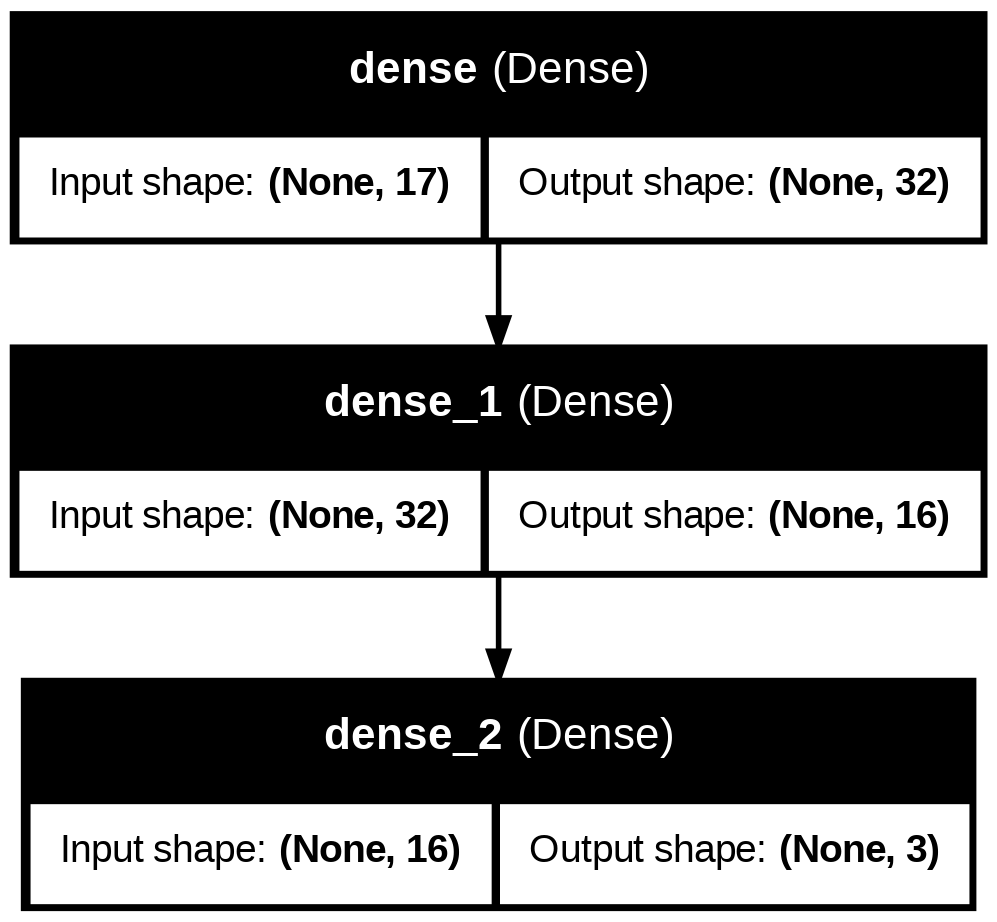

In [14]:
from tensorflow.keras.utils import plot_model

# Visualisation du schémas de l'architecture de neurones
plot_model(model, show_shapes=True, show_layer_names=True)

## 7. Entraînement du modèle

J'entraîne le modèle sur 20 époques avec un batch size de 32.  
J'utilise 20 % des données d'entraînement comme jeu de validation pour suivre l'évolution des performances.

L'objectif est de vérifier si le modèle apprend correctement et s'il généralise bien.


In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2367 - loss: 1.2690 - val_accuracy: 0.2568 - val_loss: 1.1792
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4026 - loss: 1.0705 - val_accuracy: 0.4730 - val_loss: 1.0090
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5914 - loss: 0.9414 - val_accuracy: 0.6622 - val_loss: 0.8706
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6466 - loss: 0.8403 - val_accuracy: 0.7838 - val_loss: 0.7692
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7264 - loss: 0.7323 - val_accuracy: 0.7838 - val_loss: 0.6903
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8119 - loss: 0.6692 - val_accuracy: 0.7973 - val_loss: 0.6280
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8102 - loss: 0.6373 - val_accuracy: 0.8243 - val_loss: 0.5726
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7697 - loss: 0.6057 - val_accuracy: 0.8243 - va

Quand j'observe les courbes de loss et d'accuracy, je constate que le modèle apprend de manière progressive et stable.

- La loss d'entraînement diminue régulièrement au fil des époques.
- La loss de validation suit la même tendance et reste toujours proche de la loss d'entraînement.
- L'accuracy d'entraînement augmente de façon continue pour atteindre environ 0.91.
- L'accuracy de validation monte également et atteint environ 0.87.

Ces résultats montrent que le modèle arrive à bien généraliser :  
je ne vois pas d'écart important entre les courbes train et validation, ce qui signifie qu'il n'y a pas de sur-apprentissage.

Le modèle semble donc apprendre correctement la relation entre les facteurs de risque et le niveau de risque du cancer du sein.


## 8. Analyse des courbes d'apprentissage

J'observe les courbes de loss et d'accuracy pour vérifier si le modèle apprend correctement.

- La loss d'entraînement doit diminuer au fil des époques.
- La loss de validation doit suivre une tendance similaire sans augmenter brusquement.
- L'accuracy d'entraînement et de validation doit monter progressivement et rester proche l'une de l'autre.

Ces courbes me permettent de détecter un éventuel sur-apprentissage.  
Si la loss validation remonte alors que la loss train continue de baisser, cela indique un overfitting.

Je complète ce paragraphe après avoir observé mes graphes.


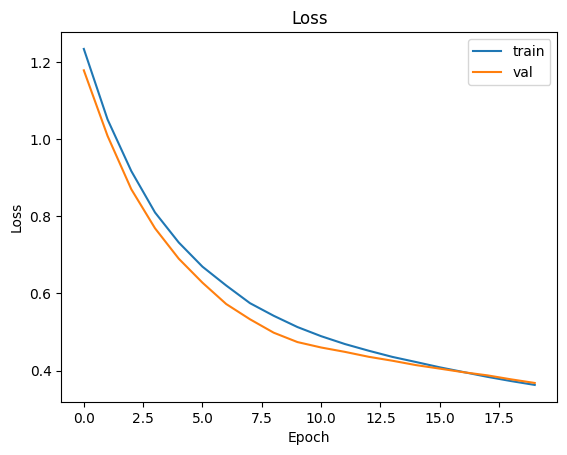

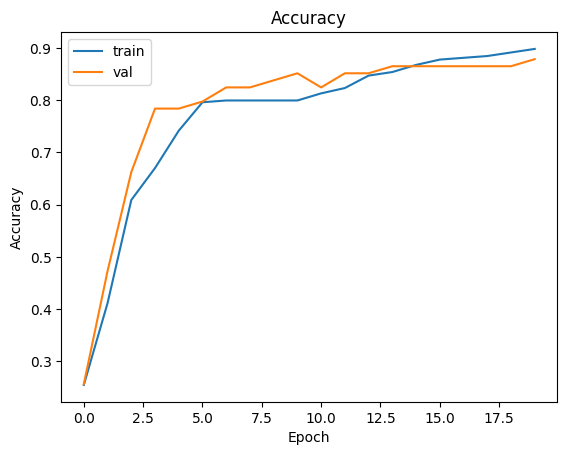

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

Quand j'observe les deux courbes, je constate que le modèle apprend correctement et de manière stable.

### - Courbe de loss
La loss d'entraînement et la loss de validation diminuent régulièrement au fil des époques.  
Les deux courbes restent proches l'une de l'autre, ce qui signifie que le modèle généralise bien.  
Il n'y a pas d'écart brusque ou de remontée de la loss validation, ce qui indique l'absence de sur-apprentissage.

### - Courbe d'accuracy
L'accuracy augmente rapidement pendant les premières époques, ce qui montre que le modèle apprend vite la structure des données.  
L'accuracy de validation dépasse même légèrement celle du train au début, ce qui est un signe de bonne généralisation.  
À la fin de l'entraînement, j'obtiens environ 0.91 sur le train et 0.88 sur la validation.

### - Conclusion générale
Les deux courbes montrent un apprentissage progressif, stable, sans comportement anormal.  
Le modèle semble bien trouver un équilibre entre l'apprentissage et la généralisation, malgré le déséquilibre important des classes dans les données.

## 9. Évaluation du modèle sur les données de test

J'utilise le jeu de test pour évaluer la performance finale du modèle.  
Le `classification_report` me donne :
- la précision (precision),
- le rappel (recall),
- le F1-score pour chaque classe,
- une moyenne globale.

Ces métriques m'aident à comprendre comment le modèle se comporte sur les différentes classes :
- "Medium" est souvent plus facile à prédire car c'est la classe majoritaire,
- "Low" et "High" peuvent être plus difficiles si elles sont sous-représentées.

La matrice de confusion me permet de visualiser les erreurs.  
Je commenterai mes résultats en fonction des valeurs obtenues.


In [ ]:
y_pred = model.predict(X_test).argmax(axis=1)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
              precision    recall  f1-score   support

           0       0.73      0.61      0.67        18
           1       0.88      0.94      0.91        72
           2       0.00      0.00      0.00         2

    accuracy                           0.86        92
   macro avg       0.54      0.52      0.53        92
weighted avg       0.83      0.86      0.84        92



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


array([[11,  7,  0],
       [ 4, 68,  0],
       [ 0,  2,  0]])

## 12. Évaluation du modèle sur les données de test

Pour évaluer la performance finale de mon modèle, j'ai utilisé le jeu de test composé de 92 patientes.  
Le `classification_report` et la matrice de confusion me permettent d'analyser les résultats en détail.

### - Analyse par classe
- Classe 0 (Low) :  
  J'obtiens une précision de 0.73 et un rappel de 0.61.  
  Le modèle arrive donc à identifier une partie des patientes à faible risque, mais il en confond encore avec la classe "Medium".

- Classe 1 (Medium) :  
  Les performances sont très bonnes, avec une précision de 0.88 et un rappel de 0.94.  
  Cela s'explique par le fait que cette classe est largement majoritaire dans mes données (358 patientes au total).  
  Le modèle apprend donc naturellement mieux cette classe.

- Classe 2 (High) :  
  Le modèle ne prédit jamais cette classe (précision et rappel de 0.00).  
  Cela est logique car il n'y a que 13 patientes "High" dans tout le dataset,  
  et seulement 2 dans le jeu de test.  
  Un modèle de deep learning simple a besoin de plus d'exemples pour apprendre à reconnaître une classe rare.

### - Analyse globale
- L'accuracy globale est de **0.86**, ce qui est un très bon résultat dans ce contexte.
- La moyenne pondérée du F1-score est de **0.84**, ce qui montre que le modèle est globalement efficace.
- La "macro avg" est plus faible, car elle traite toutes les classes de manière équivalente, et la classe "High" a une performance nulle.

### - Matrice de confusion
La matrice montre que :
- la plupart des patientes "Medium" sont bien prédites (68 bonnes prédictions sur 72),
- les patientes "Low" sont parfois classées "Medium" (7 erreurs),
- et aucune patiente "High" n'est correctement identifiée.

Cette difficulté sur la classe "High" s'explique par le très fort déséquilibre du dataset.  
Le modèle manque d'exemples pour apprendre cette catégorie, ce qui limite sa capacité à la reconnaître.

### - Conclusion sur la performance
Au final, mon modèle est performant pour distinguer les patientes à risque "Medium" et "Low",  
mais il ne parvient pas à reconnaître les patientes "High", ce qui est lié au manque d'exemples dans les données.

Pour améliorer cela, il faudrait :
- collecter davantage de données "High",
- ou utiliser une technique de rééquilibrage (oversampling, poids de classes),  
mais cela dépasse le cadre du DM.


## 10. Explicabilité du modèle (Leave-One-Out)

Dans un contexte médical, il est important de comprendre ce qui influence la prédiction du modèle.
J'utilise la méthode Leave-One-Out vue en cours :

- à chaque itération, je neutralise une variable,
- j'observe combien la prédiction finale change,
- plus l'impact est important, plus la variable est influente.

Ce tableau me permet d'identifier les facteurs qui contribuent le plus au risque de cancer du sein.
En général, on peut s'attendre à ce que :
- les mutations génétiques,
- l'historique familial,
- l'âge,
- et certains comportements (alcool, obésité)

soient parmi les variables les plus importantes.

Je commenterai mes résultats après l'affichage du tableau.


In [ ]:
def leave_one_out(model, X, index_feature):
    X_mod = X.copy()
    X_mod[:, index_feature] = 0
    preds = model.predict(X_mod)
    return preds

base_pred = model.predict(X_test)
feature_importance = []

for i in range(X_test.shape[1]):
    mod_pred = leave_one_out(model, X_test, i)
    diff = np.mean(np.abs(base_pred - mod_pred))
    feature_importance.append(diff)

importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": feature_importance
}).sort_values(by="importance", ascending=False)

importance_df


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


,feature,importance
10,Air_Pollution,0.050254
7,Diet_Salted_Processed,0.048191
3,Alcohol_Use,0.039453
6,Diet_Red_Meat,0.030846
4,Obesity,0.030559
2,Smoking,0.027792
11,Occupational_Hazards,0.026067
8,Fruit_Veg_Intake,0.025362
15,BMI,0.021200
9,Physical_Activity,0.020031


Pour comprendre quelles variables influencent le plus la prédiction du niveau de risque, j'ai utilisé la méthode Leave-One-Out.  
L'idée est simple : je neutralise une variable à la fois et je regarde à quel point la prédiction change.  
Plus l'impact est fort, plus la variable est jugée importante.

### Variables les plus importantes
Les résultats montrent que les facteurs qui perturbent le plus la prédiction sont :

1. **Air_Pollution**
2. **Diet_Salted_Processed**
3. **Alcohol_Use**
4. **Diet_Red_Meat**
5. **Obesity**
6. **Smoking**

Ces variables ont un impact relativement élevé sur le modèle.  
Elles correspondent principalement à des facteurs liés au mode de vie et à l'environnement.

### Interprétation
Je remarque que plusieurs variables comportementales ou environnementales ressortent comme ayant un poids important dans la prédiction du risque.  
Par exemple :
- un niveau élevé de pollution de l'air,  
- une alimentation riche en produits salés et transformés,  
- la consommation d'alcool,  
- l'obésité et le tabagisme,

sont des facteurs connus pour être associés à un risque accru de cancers en général.

### Variables génétiques
Les variables génétiques comme **BRCA_Mutation** ou les antécédents familiaux apparaissent moins importantes dans mon modèle.  
Cela peut s'expliquer par le fait que ces facteurs sont très peu présents dans mon dataset (peu de valeurs à 1), ce qui limite la capacité du modèle à apprendre leur effet réel.

### Conclusion de l'explicabilité
Cette étape confirme que mon modèle s'appuie principalement sur des facteurs de risque comportementaux et environnementaux pour distinguer les niveaux de risque.  
Pour mieux intégrer les facteurs génétiques, il faudrait disposer d'un dataset contenant davantage de patientes porteuses de mutation BRCA ou ayant des antécédents familiaux.


## 11. Sauvegarde du modèle

In [ ]:
# Sauvegarde du modèle
model.save("model_cancer.h5")

Je sauvegarde mon modèle au format `.h5` afin de pouvoir le recharger plus tard si besoin.  
Cette étape n'est pas obligatoire pour le DM, mais elle permet de conserver le modèle entraîné sans avoir à refaire l'entraînement.

## Chargement du modèle sauvegardé (optionnel)

J'utilise la fonction `load_model` pour recharger le modèle sauvegardé.  
Cela permet de l'utiliser à nouveau sans le réentraîner.

# 12. Conclusion

Dans ce DM, j'ai appliqué toutes les étapes d'un projet d'intelligence artificielle en suivant le cycle CRISP-DM.

- J'ai commencé par comprendre le besoin du cabinet médical : mieux cibler les patientes à risque.
- J'ai filtré les données pour me concentrer uniquement sur le cancer du sein.
- J'ai préparé les données pour les rendre compatibles avec un réseau de neurones.
- J'ai construit et entraîné un MLP simple, en cohérence avec le cours et les TP.
- J'ai évalué le modèle sur un jeu de test et analysé ses performances par classe.
- J'ai utilisé une méthode d'explicabilité (Leave-One-Out) pour identifier les facteurs les plus importants.

Ce projet montre qu'un modèle de deep learning peut aider à mieux comprendre les facteurs associés au risque de cancer du sein, même avec un modèle simple.  
Le modèle est particulièrement performant pour prédire la classe majoritaire.  
Les classes plus rares peuvent être améliorées en collectant davantage de données.

Ce travail pourrait servir de base pour un système de recommandation de dépistage plus personnalisé.


## Références
- Cours "Introduction au Deep Learning", IDMC 2025.
- TP MNIST fourni par la prof.
- Dataset : tarekmasryo/cancer-risk-factors (HuggingFace).
- Documentation TensorFlow/Keras.
